In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
x = pd.read_csv("/content/drive/MyDrive/M1 DS/Data_step2/x_featured_6lags.csv")
y = pd.read_csv("/content/drive/MyDrive/M1 DS/Data_step2/y_ready2.csv")
y = y.drop("Unnamed: 0",axis=1)
x = x.drop("Unnamed: 0",axis=1)



In [3]:
import gc
gc.collect()

0

In [ ]:
import xgboost as xgb
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3,random_state=42)

dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)

model = xgb.XGBModel()
params = {
    'max_depth': 10,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'booster':'dart',
    'sample_type':'weighted',
    'normalize_type':'forest',
    'learning_rate':0.4,
    'tree_method':'hist',
    'n_jobs':500,
    'rate_drop':0.3,
    'skip_drop':0.2,

}

# Train model
evalist = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(params, dtrain,num_boost_round=50,verbose_eval=1,evals=evalist)

preds = model.predict(dtest) #Predictions
y_test = y_test.astype(float)
optimal_num_boost_round = model.best_iteration

print("Precision = {}".format(average_precision_score(y_test.values, preds, average='macro')))
print("Precision = {}".format(average_precision_score(y_test.values, preds, average='micro')))


# print("Precision = {}".format(average_precision_score(y_test.values, preds, average='weighted')))



# with two shifts and rolling mean
# [49]	train-error:0.01084	eval-error:0.01094
# Precision = 0.360295215322127
# Precision = 0.5547346929659036 



# with three shifts and rolling mean and learning on 60% of the dataset
# [49]	train-error:0.01046	eval-error:0.01063
# Precision = 0.39536917607185706
# Precision = 0.5826071890464899

# with Four shifts and rolling mean and learning on 70% of the dataset

# [49]	train-error:0.01019	eval-error:0.01038
# Precision = 0.42499362377939676
# Precision = 0.6024224722194952

# with Four shifts and rolling mean and rolling mean 5 std and median with interpolate replacement of NaN and learning on 70% of the dataset
# [49]	train-error:0.01004	eval-error:0.01020
# Precision = 0.4401227804610085
# Precision = 0.6162723567336617

[0]	train-error:0.01054	eval-error:0.01055


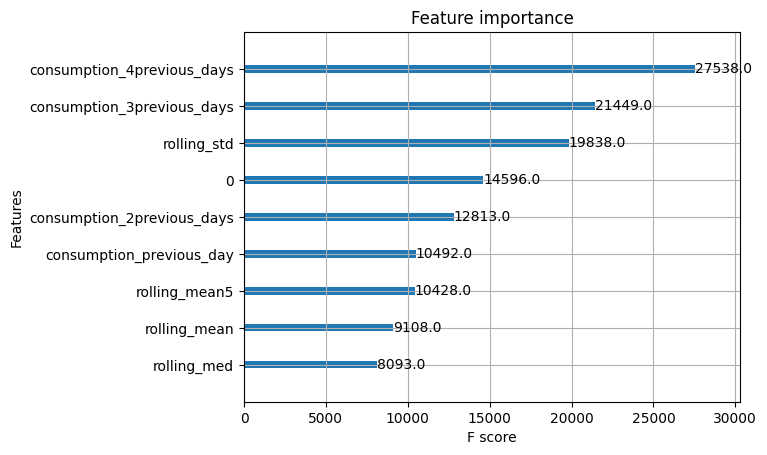

In [8]:
import matplotlib.pyplot as plt
xgb.plot_importance(model)
plt.show()


In [9]:
dfxTest= pd.read_csv("/content/drive/MyDrive/M1 DS/Data_step2/dfTest_transposed_notNormalized.csv")


In [11]:
dfxTest = dfxTest.drop('Unnamed: 0',axis = 1)
dfxTest['consumption_previous_day'] = dfxTest['0'].shift(1)
dfxTest['consumption_2previous_days'] = dfxTest['0'].shift(2)
dfxTest['consumption_3previous_days'] = dfxTest['0'].shift(3)
dfxTest['consumption_4previous_days'] = dfxTest['0'].shift(4)


dfxTest.loc[0, 'consumption_previous_day'] = dfxTest.consumption_previous_day[dfxTest.consumption_previous_day.notnull()].values[0]
dfxTest.loc[0, 'consumption_2previous_days'] = dfxTest.consumption_previous_day[dfxTest.consumption_previous_day.notnull()].values[0]
dfxTest.loc[1, 'consumption_2previous_days'] = dfxTest.consumption_previous_day[dfxTest.consumption_previous_day.notnull()].values[1]
dfxTest.loc[0, 'consumption_3previous_days'] = dfxTest.consumption_previous_day[dfxTest.consumption_previous_day.notnull()].values[0]
dfxTest.loc[1, 'consumption_3previous_days'] = dfxTest.consumption_previous_day[dfxTest.consumption_previous_day.notnull()].values[1]
dfxTest.loc[2, 'consumption_3previous_days'] = dfxTest.consumption_previous_day[dfxTest.consumption_previous_day.notnull()].values[2]
dfxTest.loc[0, 'consumption_4previous_days'] = dfxTest.consumption_previous_day[dfxTest.consumption_previous_day.notnull()].values[0]
dfxTest.loc[1, 'consumption_4previous_days'] = dfxTest.consumption_previous_day[dfxTest.consumption_previous_day.notnull()].values[1]
dfxTest.loc[2, 'consumption_4previous_days'] = dfxTest.consumption_previous_day[dfxTest.consumption_previous_day.notnull()].values[2]
dfxTest.loc[3, 'consumption_4previous_days'] = dfxTest.consumption_previous_day[dfxTest.consumption_previous_day.notnull()].values[3]

dfxTest["rolling_mean"] = dfxTest['0'].rolling(3).mean()
dfxTest["rolling_mean5"] = dfxTest['0'].rolling(5).mean()

dfxTest["rolling_med"] = dfxTest['0'].rolling(3).median()
dfxTest["rolling_std"] = dfxTest['0'].rolling(3).std()

dfxTest['rolling_mean'] = dfxTest['rolling_mean'].interpolate(method='linear', limit_direction='both')
dfxTest['rolling_mean5'] = dfxTest['rolling_mean5'].interpolate(method='linear', limit_direction='both')

dfxTest['rolling_med'] = dfxTest['rolling_med'].interpolate(method='linear', limit_direction='both')
dfxTest['rolling_std'] = dfxTest['rolling_std'].interpolate(method='linear', limit_direction='both')


In [12]:
dFin = xgb.DMatrix(dfxTest)

preds_f = model.predict(dFin)

dfF = pd.DataFrame(preds_f, columns=["Washing Machine","Dishwasher","Tumble Dryer","Microwave","Kettle"])
dfF = dfF.rename_axis('Index')
dfF = dfF.round(4)
dfF.to_csv("/content/drive/MyDrive/M1 DS/Data_step2/testFstd.csv")
